# eBird API - Species & Time Period Downloader
Download bird observations by **region code** OR **geographic location** for any time period.

**New Feature**: Download specific species across all European countries!

## 1. Setup and Imports

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
from typing import List, Optional
import json

## 2. Configuration

In [ ]:
# Your eBird API key
API_KEY = "tmb363lktsir"

# ========== CHOOSE ONE MODE ==========
# Mode 1: Single Region/Country
USE_SINGLE_REGION = False
COUNTRY_CODE = "RO"  # Romania
REGION_CODE = None    # Optional: use specific region like "RO-CV" for Covasna

# Mode 2: Multiple Countries (e.g., all of Europe)
USE_MULTIPLE_COUNTRIES = True
# European country codes (eBird uses ISO 3166-1 alpha-2 codes)
EUROPEAN_COUNTRIES = [
    'AL', 'AD', 'AT', 'BY', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ',
    'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT',
    'XK', 'LV', 'LI', 'LT', 'LU', 'MT', 'MD', 'MC', 'ME', 'NL',
    'MK', 'NO', 'PL', 'PT', 'RO', 'RU', 'SM', 'RS', 'SK', 'SI',
    'ES', 'SE', 'CH', 'TR', 'UA', 'GB', 'VA'
]

# Or use a custom list of countries
CUSTOM_COUNTRIES = ['SK', 'SI',
    'ES', 'SE', 'CH', 'TR', 'UA', 'GB', 'VA']  # e.g., ['RO', 'BG', 'HU'] for Romania, Bulgaria, Hungary

# Mode 3: By Geographic Coordinates (limited to recent data)
USE_LOCATION = False
LATITUDE = 45.8438205
LONGITUDE = 26.183044
RADIUS_KM = 50

# Date range
START_DATE = "2022-01-01"  # Format: YYYY-MM-DD
END_DATE = "2022-12-31"    # Format: YYYY-MM-DD

# Species filter - ADD YOUR TARGET SPECIES HERE
TARGET_SPECIES = [
    'whimbr',    # Whimbrel
    'litsti',    # Little Stint
    'cursan',    # Curlew Sandpiper
    'gresan',    # Green Sandpiper
    'blater',    # Black Tern
    'eurhob1',   # Honey Buzzard
    'redkno',    # Red Knot
    'ruff',      # Ruff
    'gargan',    # Garganey
    'woosan',    # Wood Sandpiper
    'osprey',    # Osprey
    'sander',    # Sanderling
    'greypl',    # Grey Plover
]

# API parameters
MAX_RESULTS_PER_REQUEST = 10000  # eBird API limit
INCLUDE_PROVISIONAL = False
HOTSPOT_ONLY = False

# Rate limiting (important when querying multiple countries)
DELAY_BETWEEN_REQUESTS = 1.0 # seconds between date requests
DELAY_BETWEEN_COUNTRIES = 5.0  # seconds between countries

## 3. Helper Functions

In [18]:
def generate_date_range(start_date: str, end_date: str) -> List[str]:
    """Generate list of dates in eBird API format (YYYY/M/D)."""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    date_list = []
    current_date = start
    
    while current_date <= end:
        date_str = f"{current_date.year}/{current_date.month}/{current_date.day}"
        date_list.append(date_str)
        current_date += timedelta(days=1)
    
    return date_list


def fetch_observations_by_region(region: str, date: str, api_key: str,
                                 max_results: int = 500, 
                                 hotspot: bool = False,
                                 include_provisional: bool = True) -> List[dict]:
    """Fetch bird observations for a specific date and region."""
    url = f"https://api.ebird.org/v2/data/obs/{region}/historic/{date}"
    
    params = {
        "detail": "full",
        "hotspot": str(hotspot).lower(),
        "maxResults": max_results,
        "includeProvisional": str(include_provisional).lower(),
        "sppLocale": "en"
    }
    
    headers = {"X-eBirdApiToken": api_key}
    
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {date}: {e}")
        return []


def filter_by_species(observations: List[dict], species_codes: List[str]) -> List[dict]:
    """Filter observations by species codes."""
    if not species_codes:
        return observations
    return [obs for obs in observations if obs.get('speciesCode') in species_codes]


def collect_observations_by_region(region: str, date_range: List[str], api_key: str,
                                   species_filter: Optional[List[str]] = None,
                                   max_results: int = 500,
                                   hotspot: bool = False,
                                   include_provisional: bool = True,
                                   delay: float = 0.5) -> List[dict]:
    """Collect observations across multiple dates."""
    all_observations = []
    
    for i, date in enumerate(date_range, 1):
        observations = fetch_observations_by_region(
            region=region, date=date, api_key=api_key,
            max_results=max_results, hotspot=hotspot,
            include_provisional=include_provisional
        )
        
        if species_filter:
            observations = filter_by_species(observations, species_filter)
        
        all_observations.extend(observations)
        
        if i < len(date_range):
            time.sleep(delay)
    
    return all_observations


def collect_observations_multi_country(countries: List[str], 
                                       date_range: List[str],
                                       api_key: str,
                                       species_filter: Optional[List[str]] = None,
                                       max_results: int = 500,
                                       hotspot: bool = False,
                                       include_provisional: bool = True,
                                       delay_requests: float = 0.5,
                                       delay_countries: float = 2.0) -> List[dict]:
    """Collect observations across multiple countries with checkpointing."""
    all_observations = []
    country_stats = []
    
    print(f"\n{'='*70}")
    print(f"MULTI-COUNTRY DOWNLOAD")
    print(f"{'='*70}")
    print(f"Countries: {len(countries)}")
    print(f"Date range: {len(date_range)} days")
    print(f"Species filter: {species_filter if species_filter else 'All species'}")
    print(f"{'='*70}\n")
    
    for country_idx, country in enumerate(countries, 1):
        print(f"\n[{country_idx}/{len(countries)}] Processing {country}...")
        print("-" * 50)
        
        try:
            country_observations = collect_observations_by_region(
                region=country, date_range=date_range, api_key=api_key,
                species_filter=species_filter, max_results=max_results,
                hotspot=hotspot, include_provisional=include_provisional,
                delay=delay_requests
            )
            
            all_observations.extend(country_observations)
            country_stats.append({
                'country': country,
                'observations': len(country_observations)
            })
            
            print(f"✓ {country}: {len(country_observations)} observations")
            
            # CHECKPOINT: Save after each country
            if len(all_observations) > 0:
                checkpoint_df = pd.DataFrame(all_observations)
                checkpoint_file = f"checkpoint_ebird_{country}_{len(all_observations)}_obs.csv"
                checkpoint_df.to_csv(checkpoint_file, index=False)
                print(f"  💾 Checkpoint saved: {checkpoint_file}")
            
            if country_idx < len(countries):
                time.sleep(delay_countries)
                
        except Exception as e:
            print(f"⚠️  Error processing {country}: {e}")
            print(f"  Continuing with next country...")
            continue
    
    print(f"\n{'='*70}")
    print(f"SUMMARY")
    print(f"{'='*70}")
    print(f"Total observations: {len(all_observations)}")
    print(f"\nObservations by country:")
    stats_df = pd.DataFrame(country_stats).sort_values('observations', ascending=False)
    print(stats_df.to_string(index=False))
    
    return all_observations

## 4. Fetch Data

In [21]:
# Generate date range
date_range = generate_date_range(START_DATE, END_DATE)

if USE_MULTIPLE_COUNTRIES:
    # Multi-country mode
    countries = CUSTOM_COUNTRIES if CUSTOM_COUNTRIES else EUROPEAN_COUNTRIES
    
    print(f"Using {'CUSTOM' if CUSTOM_COUNTRIES else 'ALL EUROPEAN'} countries ({len(countries)} total)")
    
    observations = collect_observations_multi_country(
        countries=countries,
        date_range=date_range,
        api_key=API_KEY,
        species_filter=TARGET_SPECIES,
        max_results=MAX_RESULTS_PER_REQUEST,
        hotspot=HOTSPOT_ONLY,
        include_provisional=INCLUDE_PROVISIONAL,
        delay_requests=DELAY_BETWEEN_REQUESTS,
        delay_countries=DELAY_BETWEEN_COUNTRIES
    )

elif USE_SINGLE_REGION:
    # Single region mode
    region = REGION_CODE if REGION_CODE else COUNTRY_CODE
    print(f"Fetching data for region: {region}")
    print(f"Date range: {len(date_range)} days\n")
    
    observations = collect_observations_by_region(
        region=region,
        date_range=date_range,
        api_key=API_KEY,
        species_filter=TARGET_SPECIES,
        max_results=MAX_RESULTS_PER_REQUEST,
        hotspot=HOTSPOT_ONLY,
        include_provisional=INCLUDE_PROVISIONAL,
        delay=DELAY_BETWEEN_REQUESTS
    )
    
    print(f"\nTotal observations: {len(observations)}")

else:
    print("Please set USE_SINGLE_REGION=True or USE_MULTIPLE_COUNTRIES=True")
    observations = []

Using CUSTOM countries (9 total)

MULTI-COUNTRY DOWNLOAD
Countries: 9
Date range: 365 days
Species filter: ['whimbr', 'litsti', 'cursan', 'gresan', 'blater', 'eurhob1', 'redkno', 'ruff', 'gargan', 'woosan', 'osprey', 'sander', 'greypl']


[1/9] Processing SK...
--------------------------------------------------
✓ SK: 378 observations
  💾 Checkpoint saved: checkpoint_ebird_SK_378_obs.csv

[2/9] Processing SI...
--------------------------------------------------
✓ SI: 355 observations
  💾 Checkpoint saved: checkpoint_ebird_SI_733_obs.csv

[3/9] Processing ES...
--------------------------------------------------
✓ ES: 2521 observations
  💾 Checkpoint saved: checkpoint_ebird_ES_3254_obs.csv

[4/9] Processing SE...
--------------------------------------------------
✓ SE: 1028 observations
  💾 Checkpoint saved: checkpoint_ebird_SE_4282_obs.csv

[5/9] Processing CH...
--------------------------------------------------
✓ CH: 583 observations
  💾 Checkpoint saved: checkpoint_ebird_CH_4865_obs.c

In [24]:
# Check if data exists and save it immediately
if 'observations' in dir() and observations:
    import pandas as pd
    
    # Convert to DataFrame
    df = pd.DataFrame(observations)
    
    print(f"✓ Found {len(df)} observations!")
    print(f"Date range: {df['obsDt'].min()} to {df['obsDt'].max()}")
    print(f"Countries: {df['countryCode'].nunique()}")
    
    # Save immediately
    filename = f"ebird_partial_download_{len(df)}_observations.csv"
    df.to_csv(filename, index=False)
    print(f"\n✓ Saved to: {filename}")
    
    # Also save as JSON backup
    json_filename = filename.replace('.csv', '.json')
    df.to_json(json_filename, orient='records', date_format='iso', indent=2)
    print(f"✓ Saved to: {json_filename}")
    
    # Show summary
    print("\n" + "="*60)
    print("COUNTRIES DOWNLOADED:")
    print("="*60)
    country_counts = df.groupby('countryCode').size().sort_values(ascending=False)
    print(country_counts.to_string())
    
else:
    print("✗ No data found. The variable may have been cleared.")

✓ Found 19 observations!
Date range: 2022-01-01 16:00 to 2022-01-29 07:40
Countries: 2

✓ Saved to: ebird_partial_download_19_observations.csv
✓ Saved to: ebird_partial_download_19_observations.json

COUNTRIES DOWNLOADED:
countryCode
AD    16
AL     3


## 5. Convert to DataFrame and Explore

In [26]:
df = pd.DataFrame(observations)

if len(df) > 0:
    df['obsDt'] = pd.to_datetime(df['obsDt'])
    df = df.sort_values('obsDt')
    
    print(f"\nDataFrame shape: {df.shape}")
    print(f"Date range: {df['obsDt'].min()} to {df['obsDt'].max()}")
    print(f"Countries: {df['countryCode'].nunique()}")
    
    display(df.head(10))
else:
    print("No observations found!")


DataFrame shape: (19, 25)
Date range: 2022-01-01 16:00:00 to 2022-01-29 07:40:00
Countries: 2


,speciesCode,comName,sciName,locId,locName,obsDt,lat,lng,obsValid,obsReviewed,...,countryName,userDisplayName,obsId,checklistId,presenceNoted,hasComments,hasRichMedia,firstName,lastName,howMany
3,gretit1,Great Tit,Parus major,L1120128,Andorra la Vella,2022-01-01 16:00:00,42.506300,1.521700,True,False,...,Andorra,Jan Lock,OBS1307802994,CL26036,False,False,False,Jan,Lock,2.0
4,houspa,House Sparrow,Passer domesticus,L1120128,Andorra la Vella,2022-01-01 16:00:00,42.506300,1.521700,True,False,...,Andorra,Jan Lock,OBS1307802993,CL26036,False,False,False,Jan,Lock,2.0
5,eurbul,Eurasian Bullfinch,Pyrrhula pyrrhula,L1120128,Andorra la Vella,2022-01-01 16:00:00,42.506300,1.521700,True,False,...,Andorra,Jan Lock,OBS1308389211,CL26036,False,False,False,Jan,Lock,2.0
6,gretit1,Great Tit,Parus major,L17295018,Coll de la Gallina,2022-01-02 11:00:00,42.459306,1.449930,True,False,...,Andorra,Jan Lock,OBS1308715680,CL26036,False,False,False,Jan,Lock,4.0
7,houspa,House Sparrow,Passer domesticus,L17295018,Coll de la Gallina,2022-01-02 11:00:00,42.459306,1.449930,True,False,...,Andorra,Jan Lock,OBS1308671705,CL26036,True,False,False,Jan,Lock,NaN
9,whtdip1,White-throated Dipper,Cinclus cinclus,L17321481,camino de Rocafort,2022-01-03 15:00:00,42.456959,1.480112,True,False,...,Andorra,Jan Lock,OBS1310490098,CL26036,False,False,False,Jan,Lock,1.0
8,gretit1,Great Tit,Parus major,L17321481,camino de Rocafort,2022-01-03 15:00:00,42.456959,1.480112,True,False,...,Andorra,Jan Lock,OBS1310490094,CL26036,False,False,False,Jan,Lock,4.0
10,whtdip1,White-throated Dipper,Cinclus cinclus,L16795485,Sant Julia,2022-01-04 17:00:00,42.466221,1.492243,True,False,...,Andorra,Jan Lock,OBS1310817249,CL26036,False,False,False,Jan,Lock,1.0
11,whtdip1,White-throated Dipper,Cinclus cinclus,L1120128,Andorra la Vella,2022-01-07 13:30:00,42.506300,1.521700,True,False,...,Andorra,João Cabral,OBS1313081470,CL26036,False,False,False,João,Cabral,4.0
12,houspa,House Sparrow,Passer domesticus,L1120128,Andorra la Vella,2022-01-07 13:30:00,42.506300,1.521700,True,False,...,Andorra,João Cabral,OBS1313081477,CL26036,False,False,False,João,Cabral,2.0


## 6. Summary Statistics

In [27]:
if len(df) > 0:
    print("=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    
    # Species summary
    print("\n📊 Species Summary:")
    species_counts = df.groupby(['speciesCode', 'comName']).size().reset_index(name='count')
    species_counts = species_counts.sort_values('count', ascending=False)
    print(species_counts.to_string(index=False))
    
    # Country summary (if multiple countries)
    if df['countryCode'].nunique() > 1:
        print("\n🌍 Observations by Country:")
        country_counts = df.groupby(['countryCode', 'countryName']).size().reset_index(name='count')
        country_counts = country_counts.sort_values('count', ascending=False)
        print(country_counts.to_string(index=False))
    
    # Observations by date
    print("\n📅 Observations by Date:")
    daily_counts = df.groupby(df['obsDt'].dt.date).size()
    print(daily_counts.to_string())
    
    # Top locations
    print("\n📍 Top Locations:")
    location_counts = df.groupby(['locName', 'countryCode']).size().reset_index(name='count')
    location_counts = location_counts.sort_values('count', ascending=False).head(10)
    print(location_counts.to_string(index=False))
    
    print(f"\n👥 Unique Observers: {df['userDisplayName'].nunique()}")
    print(f"📌 Unique Locations: {df['locName'].nunique()}")
    
    if 'howMany' in df.columns:
        total_birds = df['howMany'].sum()
        print(f"🐦 Total Individual Birds Counted: {total_birds}")

SUMMARY STATISTICS

📊 Species Summary:
speciesCode               comName  count
     houspa         House Sparrow      6
    whtdip1 White-throated Dipper      6
    gretit1             Great Tit      5
     eurbul    Eurasian Bullfinch      1
     eursta     European Starling      1

🌍 Observations by Country:
countryCode countryName  count
         AD     Andorra     16
         AL     Albania      3

📅 Observations by Date:
obsDt
2022-01-01    3
2022-01-02    2
2022-01-03    2
2022-01-04    1
2022-01-07    2
2022-01-08    1
2022-01-14    2
2022-01-15    2
2022-01-16    1
2022-01-23    2
2022-01-29    1

📍 Top Locations:
                                               locName countryCode  count
                                      Andorra la Vella          AD      6
Baixada del Molí, 31-35 AD500 Andorra la Vella Andorra          AD      2
                                    Coll de la Gallina          AD      2
                      Parku Kombëtar Divjakë-Karavasta          AL      2

## 7. Export Data

In [ ]:
if len(df) > 0:
    # Define filename
    if USE_MULTIPLE_COUNTRIES:
        if CUSTOM_COUNTRIES:
            location_str = f"countries_{'_'.join(CUSTOM_COUNTRIES[:3])}"
        else:
            location_str = "europe_all_countries"
    else:
        region = REGION_CODE if REGION_CODE else COUNTRY_CODE
        location_str = f"region_{region}"
    
    species_str = "targeted_species" if TARGET_SPECIES else "all_species"
    filename = f"ebird_{location_str}_{species_str}_{START_DATE}_to_{END_DATE}.csv"
    
    # Export to CSV
    df.to_csv(filename, index=False)
    print(f"✅ Data exported to: {filename}")
    
    # Export to JSON
    json_filename = filename.replace('.csv', '.json')
    df.to_json(json_filename, orient='records', date_format='iso', indent=2)
    print(f"✅ Data exported to: {json_filename}")
    
    # Export country summary if applicable
    if USE_MULTIPLE_COUNTRIES and df['countryCode'].nunique() > 1:
        summary_filename = filename.replace('.csv', '_country_summary.csv')
        country_summary = df.groupby(['countryCode', 'countryName']).agg({
            'obsId': 'count',
            'speciesCode': 'nunique',
            'locName': 'nunique'
        }).reset_index()
        country_summary.columns = ['countryCode', 'countryName', 'observations', 'unique_species', 'unique_locations']
        country_summary = country_summary.sort_values('observations', ascending=False)
        country_summary.to_csv(summary_filename, index=False)
        print(f"✅ Country summary exported to: {summary_filename}")
else:
    print("⚠️ No data to export")

✅ Data exported to: ebird_countries_AL_AD_eurbul_tawowl1_eurnut1_gswwoo1_houspa_whtdip1_eurwre1_gretit1_blutit1_eurrob_sedwar1_garwar1_wilwar_eurnig1_blackc1_eursta_comcra_arcter_barswa_comcuc1_eurbee1_2022-01-01_to_2022-01-31.csv
✅ Data exported to: ebird_countries_AL_AD_eurbul_tawowl1_eurnut1_gswwoo1_houspa_whtdip1_eurwre1_gretit1_blutit1_eurrob_sedwar1_garwar1_wilwar_eurnig1_blackc1_eursta_comcra_arcter_barswa_comcuc1_eurbee1_2022-01-01_to_2022-01-31.json
✅ Country summary exported to: ebird_countries_AL_AD_eurbul_tawowl1_eurnut1_gswwoo1_houspa_whtdip1_eurwre1_gretit1_blutit1_eurrob_sedwar1_garwar1_wilwar_eurnig1_blackc1_eursta_comcra_arcter_barswa_comcuc1_eurbee1_2022-01-01_to_2022-01-31_country_summary.csv


## 8. Visualizations (Optional)

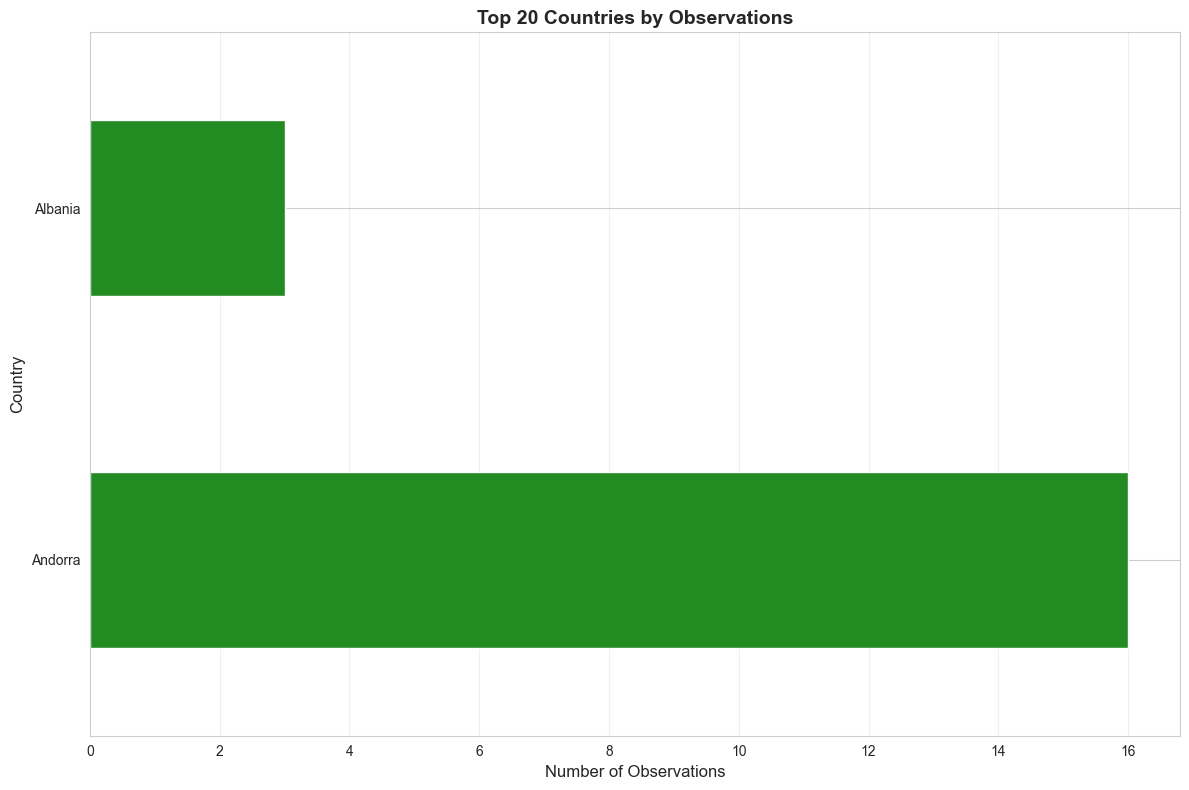

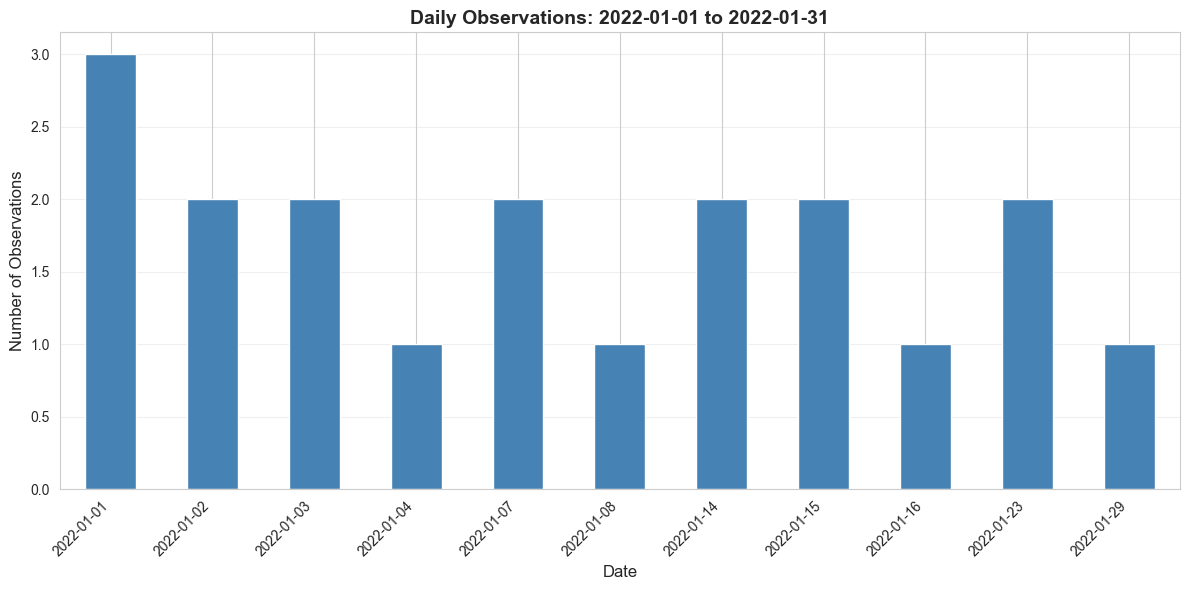

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

if len(df) > 0:
    # Country distribution (if multiple countries)
    if USE_MULTIPLE_COUNTRIES and df['countryCode'].nunique() > 1:
        fig, ax = plt.subplots(figsize=(12, 8))
        country_counts = df['countryName'].value_counts().head(20)
        country_counts.plot(kind='barh', ax=ax, color='forestgreen')
        ax.set_xlabel('Number of Observations', fontsize=12)
        ax.set_ylabel('Country', fontsize=12)
        ax.set_title('Top 20 Countries by Observations', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Time series
    fig, ax = plt.subplots(figsize=(12, 6))
    daily_obs = df.groupby(df['obsDt'].dt.date).size()
    daily_obs.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Number of Observations', fontsize=12)
    ax.set_title(f'Daily Observations: {START_DATE} to {END_DATE}', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 9. Helper: Find Species Codes

In [ ]:
def search_species(search_term: str, region: str = "RO") -> pd.DataFrame:
    """Search for species codes by common name."""
    url = f"https://api.ebird.org/v2/data/obs/{region}/recent"
    params = {"maxResults": 500}
    headers = {"X-eBirdApiToken": API_KEY}
    
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()
    
    species_df = pd.DataFrame(data)[['speciesCode', 'comName', 'sciName']].drop_duplicates()
    mask = species_df['comName'].str.contains(search_term, case=False, na=False)
    
    return species_df[mask].reset_index(drop=True)

# Example: search_species("pelican")